# Kalorimetrie Küchentischversuch - Newtonsches Abkühlungsgesetz
Author: Maximilian Groß

Datum: 16.11.2023

Gruppe: 87

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu diesem Versuch.

Wird sich das Newtonsche Abkühlungsgesetz bestätigen?

## Versuchsaufbau und Durchführung

Beschreiben Sie den Versuchsaufbau und die Versuchsdurchführung. Machen Sie ein Bild von Ihrem Aufbau und nutzen Sie dieses mit zur Beschreibung.


Für den Versuch wurde ein Tasse (grau) mit heißem Wasser befüllt. Anschließend wurde ein Temperatursensor in die Tasse gelegt, der Andere neben die Tasse. 

<img src="figures/newton.PNG" width="800">

## Versuchsauswertung

In [1]:
import numpy as np
from matplotlib import pyplot as plt
# If you plan to write functions in another module,
# you can use importlib.reload(module) to reload the module
# at the beginning of each cell in order to make the latest
# changes take effect without restart the kernel.
import importlib

# Use FST-Style, if you don't like it, you can safely delete this line.
plt.style.use("FST.mplstyle")


### Newtonsches Abkühlungsgesetz

Hinweis: Nutzen Sie die Funktionen *get_ids_from_setup* und *get_json_entry* um auf Metadaten zuzugreifen. 

Sie sollten Ihr Programm zwischen TODO und DONE implementieren, und versuchen die Anweisung zu verfolgen. Das ist aber nicht erforderlich.


#### (i) Messdaten einlesen

Messdaten werden in das Notebook eingelesen.

In [2]:
# TODO: Define the path to hdf5 file, which containing experiment data for constant.
import get_directory
import os
# Getting the directory path and adding folder/file paths to it
dir_path = get_directory.get_directory()
h5_path = os.path.join(dir_path,"data\data_newton.h5")
setup_path = os.path.join(dir_path,"data\setup_newton.json")
datasheets_path = os.path.join(dir_path,"data")

# DONE #

In [3]:
# TODO: Read all experimental data and associated metadata from HDF5 files for data processing.
# HINT: You can find information about how to access to H5 Files in the README of your Repo.
import h5py
from functions import m_json, get_id_from_setup

# Reloading module
importlib.reload(get_id_from_setup)
# Reading in experimental data:
f = h5py.File(h5_path,'r')
# Getting raw data from h5 file
raw_data = f['RawData']
# Storing all data in list
all_data = []
for key in raw_data.keys():
    all_data.append(raw_data[key])
# Splitting all_data list into two lists, one for each sensor
sensor_1_data = all_data[0]
sensor_2_data = all_data[1]
# Accessing the temperatures and timestamps in each sensors data
sensor_1_temps = np.array(sensor_1_data["temperature"])
sensor_1_time = np.array(sensor_1_data["timestamp"])
sensor_2_temps = np.array(sensor_2_data["temperature"])
sensor_2_time = np.array(sensor_2_data["timestamp"])
# Clean up starting times to start at 0 seconds
sensor_1_time = sensor_1_time-sensor_1_time[0]
sensor_2_time = sensor_2_time-sensor_2_time[0]
# Calculating the temperature difference and storing it in list
temp_difference = []
for i in range(len(sensor_1_temps)):
    temp_difference.append(sensor_2_temps[i]-sensor_1_temps[i])
# Converting list with temperature differences into numpy array
temp_difference = np.array(temp_difference)

# Reading in metadata:
metadata = m_json.get_metadata_from_setup(setup_path)
setup_id = get_id_from_setup.get_id_from_setup(setup_path)
sensor_names = []
for key in raw_data.keys():
    sensor_names.append(m_json.get_json_entry(datasheets_path,setup_id,["setup",key,'name']))
# DONE #

#### (ii) Daten Semi–log ploten

Die Zeit und Differenz zwischen der heißen Flüssigkeit und der Umgebungstemperatur wird aufgezeichnet.

Die y-Achse (Temperaturdifferenz) ist auf logarithmisch eingestellt und die x-Achse (Zeit) verwendet eine normale Skalierung.

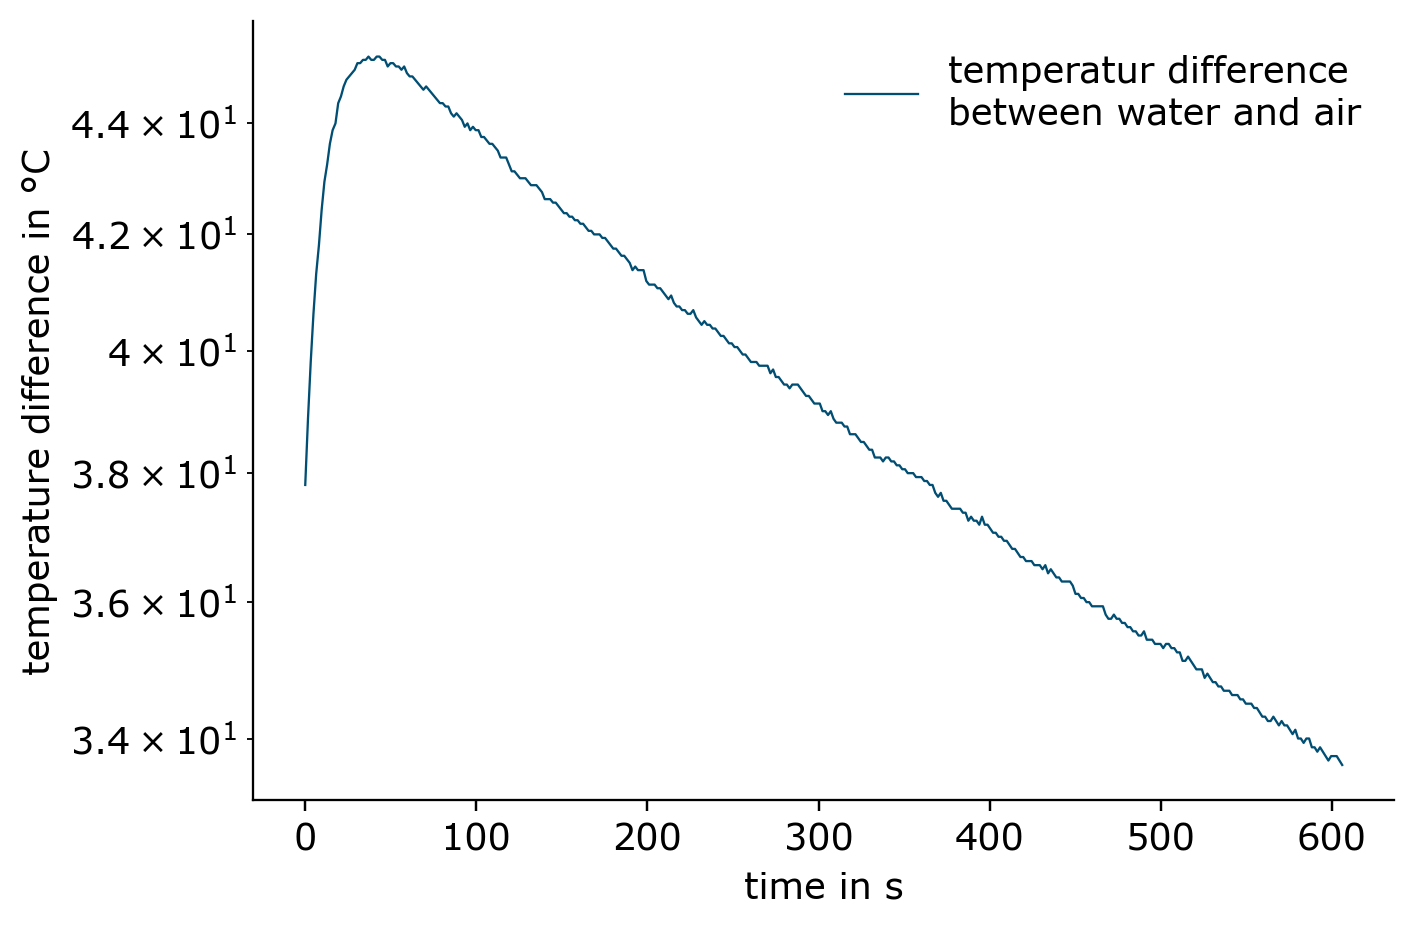

In [4]:
# TODO: Use the temperature and time data for plotting
plt.plot(sensor_1_time,temp_difference)
plt.ylabel('temperature difference in °C')
plt.xlabel('time in s')
# Changing yscale to log of base 10 does not seem to affect the plot very much, not sure why
plt.yscale("log", base=10)
plt.legend(["temperatur difference \nbetween water and air"])
plt.show()

# DONE #

#### (iii) Koeffizient in Newtonschem Abkühlungsgesetz
Die `numpy.polyfit` Funktion ist zu verwenden, um den Koeffizienten $K$ zu bestimmen.
$$
T(t) - T_2 = (T_1 - T_2)e^{Kt}
$$
Dabei ist $T(t) - T_2$ der Verlauf der Temperaturdifferenz. Die Anfangstemperatur ist $T_1$, die Endtemperatur ist $T_2$.

In [5]:
# TODO: Determine coefficient in Newtonschen Abkühlungsgesetz

# Get starting temperature:
t_1 = np.max(temp_difference)
# Get environment temperature:
t_2 = np.average(sensor_1_temps)

# Crop dataset to start at maximum temp as the rise in the beginning is likely due to sensor lag
starting_idx = np.argmax(temp_difference)
temp_difference = temp_difference[starting_idx:]
sensor_1_time = sensor_1_time[starting_idx:]
# Adjust times after cropping
sensor_1_time = sensor_1_time-sensor_1_time[0]

# Approximate dataset as first order polynomial
poly_coeff = np.polyfit(sensor_1_time,temp_difference,1)
def polynomial(t):
    value = poly_coeff[0]*t + poly_coeff[1] 
    return value

# Calculate K based on the equation given above, 
# function for K is dependend of time even though K should be a constant.
# This is to check wether or not K actually is constant over time.
def calculate_K(t):
    K = (-1)*np.log(polynomial(t)/(t_1-t_2))/t
    return K

# Sample values of K every 50 seconds
def get_some_Ks():
    Ks = []
    for i in range(12):
        Ks.append(calculate_K(50+50*i))
    return Ks
Ks = get_some_Ks()

# DONE #

#### (iV) Ergebnis

In [6]:
# TODO: Print result

for i in range(len(Ks)):
    print(f"This is K calculated at t = {50+i*50}s: {Ks[i]}")
    print("")

# DONE #

This is K calculated at t = 50s: -0.012802842720537642

This is K calculated at t = 100s: -0.006163094004424771

This is K calculated at t = 150s: -0.003945965127949385

This is K calculated at t = 200s: -0.0028343455735317723

This is K calculated at t = 250s: -0.0021648042644751243

This is K calculated at t = 300s: -0.0017161892427515915

This is K calculated at t = 350s: -0.001393713245839013

This is K calculated at t = 400s: -0.0011499750075871164

This is K calculated at t = 450s: -0.0009586329279555793

This is K calculated at t = 500s: -0.000803874437948342

This is K calculated at t = 550s: -0.000675629236663362

This is K calculated at t = 600s: -0.0005671757893397635



## Diskussion

Analysieren Sie Ihre Ergebnisse aus wissenschaflticher Sicht. Berücksichtigen Sie dabei Ihre oben genannte Forschungsfrage.
Können Sie das Newtonsche Abkühlungsgesetz bestätigen?

Das Newtonsche Abkühlungsgesetzt hat sich hier teilweise bestätigt. Je nach dem an welchem Zeitschritt man einen K Wert sampled ergibt das Newtonsche Abkühlungsgesetz mal bessere und mal weniger realistische Ergebnisse. Eigentlich sollte K natürlich eine zeitunabhängige Konstante sein. Dies ließ sich hier nicht bestätigen. Wie in den nachfolgenden Diagrammen zu sehen ist, liefert das Gesetz dennoch recht präzise Berechnungen für die tatsächliche Temperaturdifferenz, je nach dem wann man den K Wert zur Berechnung sampled. Es wäre natürlich auch möglich K als zeitabhängige Konstante anzunehmen, davon wurde im Folgenden jedoch abgesehen.

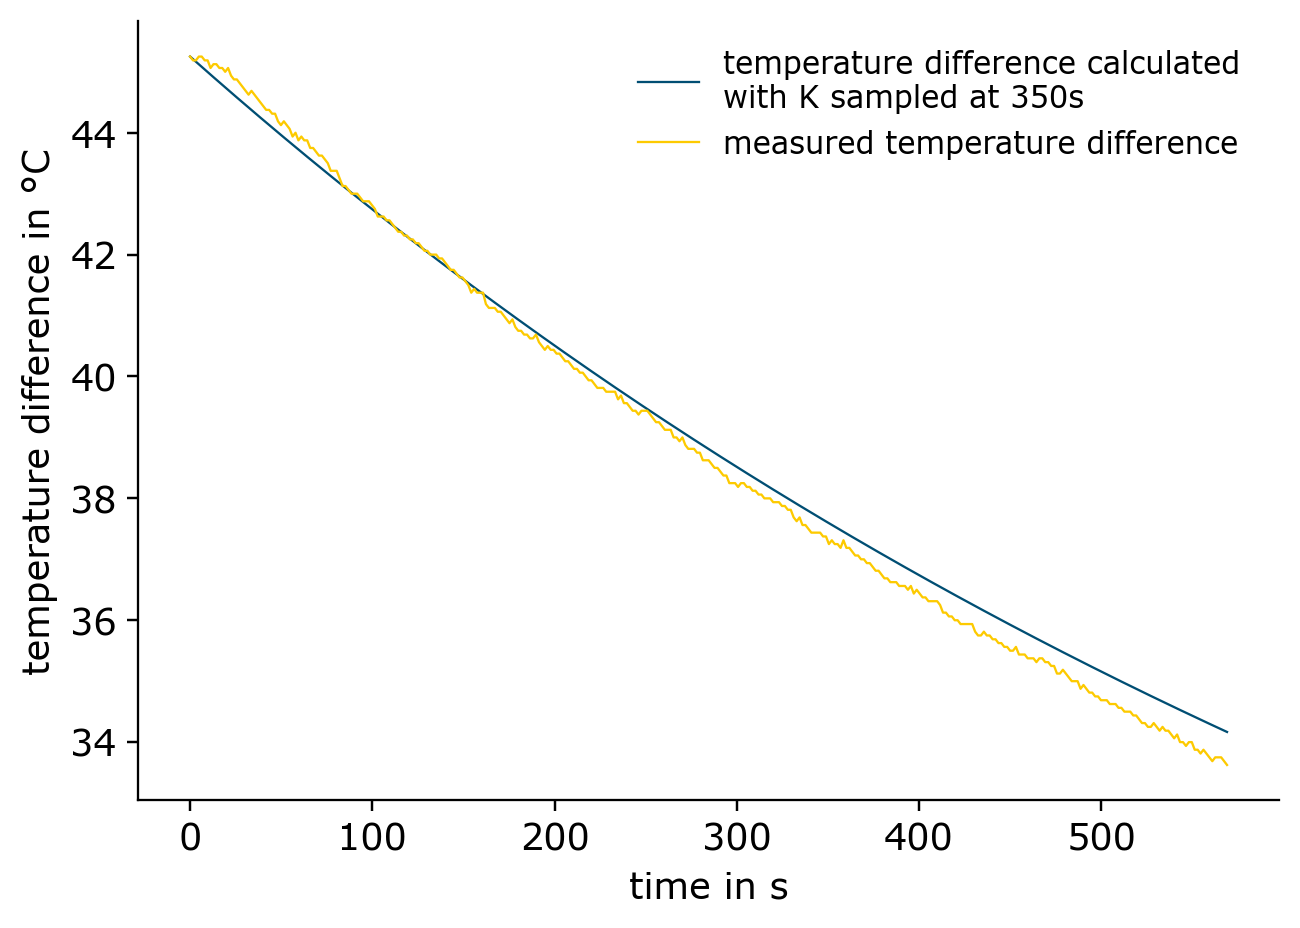

In [7]:
# To discuss results plot is created for better visualization

# Define cooling law function to calculate results
def cooling_law_fixedK(ts,K):
    temp = []
    for timestep in ts:
        temp.append((t_1-t_2)*np.e**(K*timestep)+t_2)
    return temp

# Choosing best K value
K = Ks[7] # K sampled at 350s
temps_newton = cooling_law_fixedK(sensor_1_time,K)

# Plotting
plt.plot(sensor_1_time,temps_newton)
plt.plot(sensor_1_time,temp_difference)
plt.ylabel('temperature difference in °C')
plt.xlabel('time in s')
plt.legend(['temperature difference calculated \nwith K sampled at 350s','measured temperature difference'],fontsize = 10)
plt.show()

Im Diagramm hierüber sind die tatsächlich gemessene Temperaturdifferenz (gelb) und die vom Abkühlungsgesetz vorhergesagte Temperaturdifferenz (blau) aufgetragen. Das Newtonsche Abkühlungsgesetz scheint sich hier bis auf einen geringen Fehler zu bestätigen. Die oben zu sehende Kurve ist die beste Näherung aus den anfangs gesampleten K-Werten. Im Nachfolgenden Diagramm ist zu sehen wie eine Änderung des K-Werts die Genauigkeit der Vorhersage beeinträchtigt.

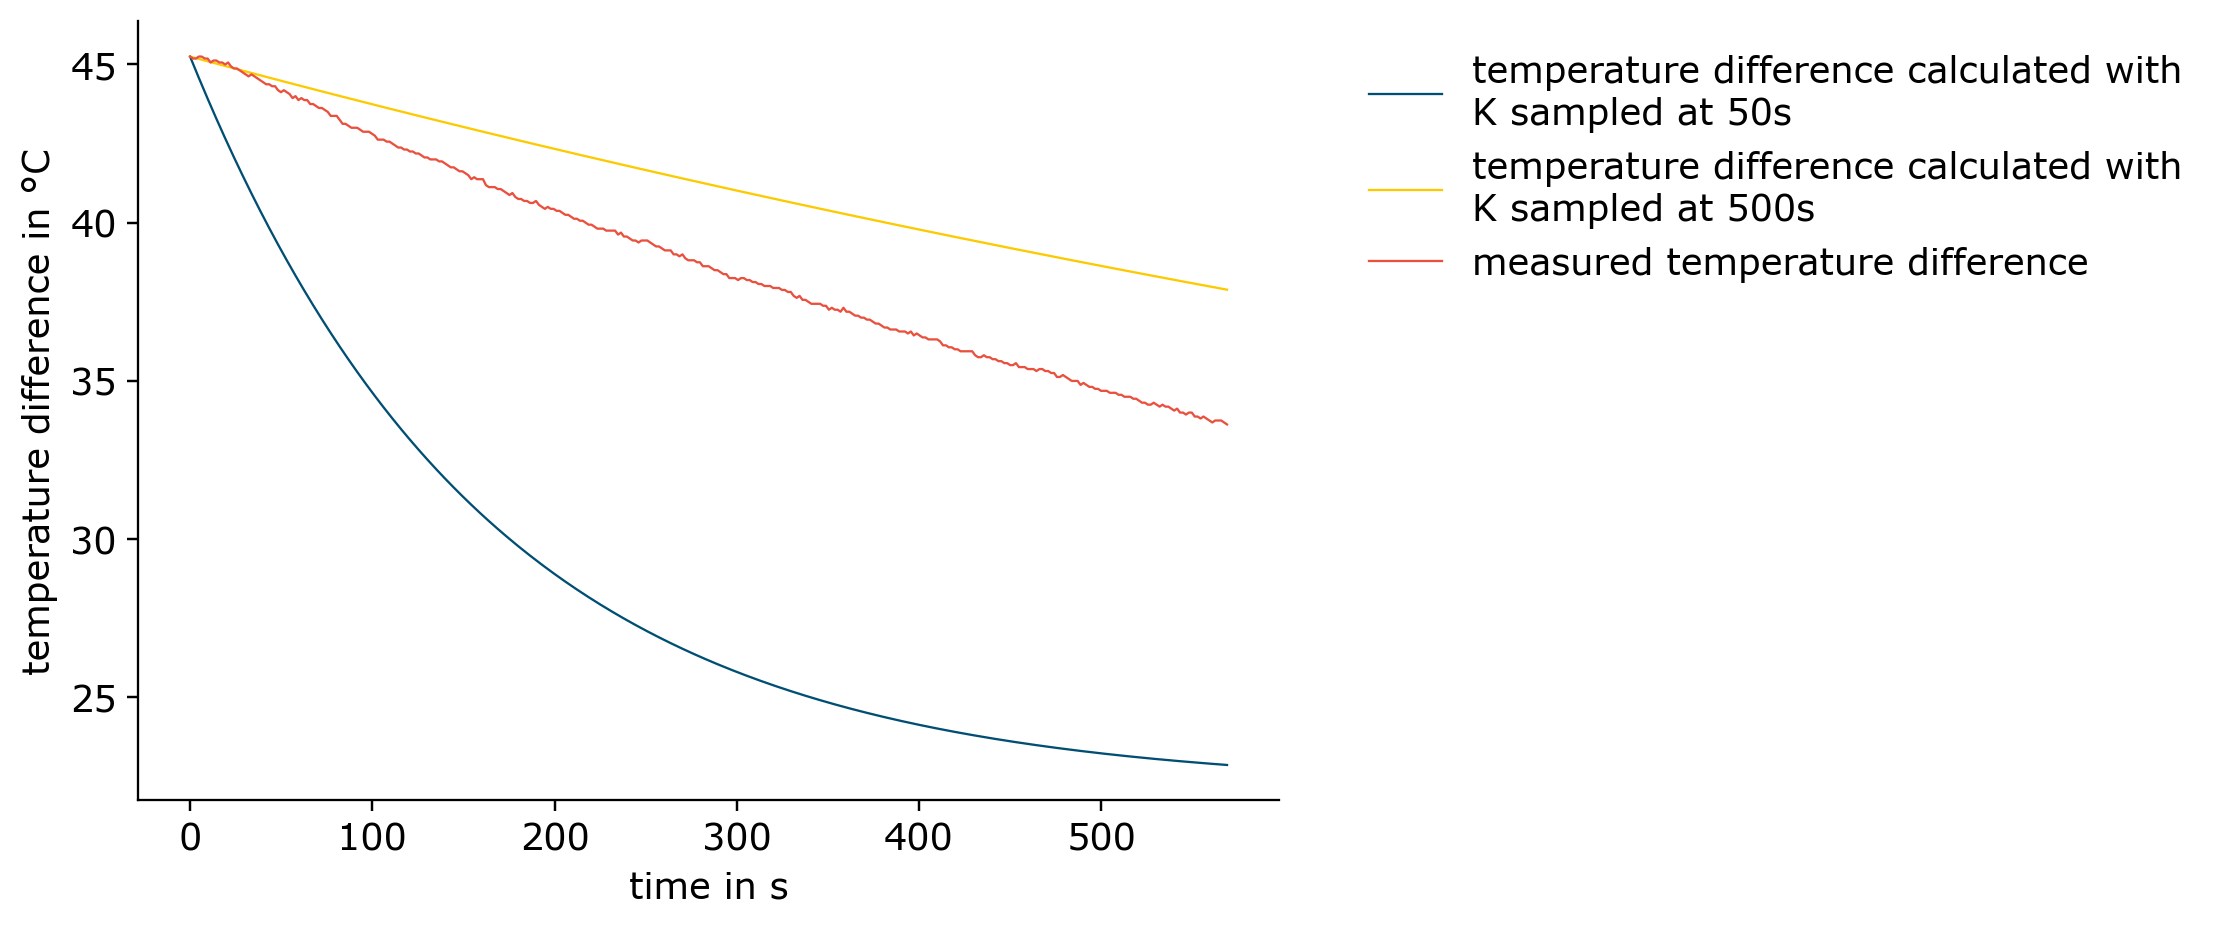

In [8]:
# To discuss results plot is created for better visualization

# Choosing worse K values
K_1 = Ks[1] # K sampled at 50s
temps_newton_1 = cooling_law_fixedK(sensor_1_time,K_1)

K_2 = Ks[10] # K sampled at 500s
temps_newton_2 = cooling_law_fixedK(sensor_1_time,K_2)

# Plotting
plt.plot(sensor_1_time,temps_newton_1,label ='temperature difference calculated with \nK sampled at 50s')
plt.plot(sensor_1_time,temps_newton_2,label='temperature difference calculated with \nK sampled at 500s')
plt.plot(sensor_1_time,temp_difference,label='measured temperature difference')
plt.ylabel('temperature difference in °C')
plt.xlabel('time in s')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Im neuen Diagramm ist gut zu erkennen wie stark die Vorhersage des Abkühlungsgesetz abweichen wenn man "schlechtere" K Werte verwendet. Warum die Ergebnisse hier so sind kann ich nur vermuten. Zunächst hatte ich vermutet, dass durch die Polynominterpolation eine Abweichung entstanden sein könnte. Das Polynom, dass die polyfit Methode berechnet, scheint allerdings sehr gut zu den Messdaten zu passen. Nach ein wenig Recherche konnte ich aber auch herausfinden, dass für den Fall eines "natürlichen" Abkühlungsprozess, also wenn es sich um konvektive Wärmeübertragung in Folge von Auftrieb der erwärmten Luft über der Tasse handelt, das Newtonsche Abkühlungsgesetz nur für relativ kleine Temperaturdifferenzen eine gute Schätzung liefert. Das bedeuted wiederum, dass der Koeffizient K bei größeren Temperaturdifferenzen eine Funktion der zeitlichen Änderung der Temperaturdifferenz ist. Das könnte die zeitliche Variabilität des Koeffizienten erklären. 
Quelle hierzu: https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling#Relationship_to_mechanism_of_cooling .

## Fazit
Ziehe Sie ein persönliches Fazit zum Versuch.

Der Versuch war interessant und die Auswertung hat zum Nachdenken angeregt.